In [58]:
import os
import matplotlib.pyplot as plt
import numpy as np
try:
    import pymysql
except:
    !pip install pymysql
    import pymysql
import pandas as pd
try:
    from ai4neb import manage_RM
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    from ai4neb import manage_RM
%matplotlib inline
dir_CSVs = 'CSVs/'
dir_figs = 'Figs/'
dir_RMs = 'RMs/'
#

In [2]:
import sklearn
print(sklearn.__version__)
import tensorflow as tf
print(tf.__version__)
import ai4neb
print(ai4neb.__version__)

0.22.1
2.3.1
0.2.8b3


In [3]:
random_seed = 42

In [4]:
def to_hdf(file_, df, metadata=None):
    with pd.HDFStore(file_) as store:
        store.put('df', df)
        store.get_storer('df').attrs.metadata = metadata                     

def read_hdf(file_):                     
    with pd.HDFStore(file_) as store:
        df = store['df']
        metadata = store.get_storer('df').attrs.metadata
    return df, metadata

In [5]:
def get_data_17(datafile='data_BOND_17_2.hdf5', force=False):
    if not os.path.exists(dir_CSVs + datafile) or force:
        sel = """SELECT
                log10(O__3_500684A/H__1_486133A) as O3,  
                log10(N__2_658345A/H__1_486133A) as N2, 
                log10(BLND_372700A/H__1_486133A) as O2, 
                log10((NE_3_386876A + NE_3_396747A)/H__1_486133A) as Ne3,
                log10(AR_3_713579A/H__1_486133A) as Ar3,
                log10(HE_1_587564A/H__1_486133A) as He1,
                log10(BLND_436300A/O__3_500684A) as rO3,
                log10(BLND_575500A/N__2_658345A) as rN2,
                NITROGEN - OXYGEN as NO,
                OXYGEN as O,
                logU_mean as logU,
                SUBSTRING(com2, 5) as fr,
                SUBSTRING(com3, 6) as age,
                HbFrac
                FROM tab_17 
                WHERE ref = 'BOND_2' """
        db = pymysql.connect(host=os.environ['MdB_HOST'], 
                                user=os.environ['MdB_USER'], 
                                passwd=os.environ['MdB_PASSWD'], 
                                db=os.environ['MdB_DB_17'])    
        res = pd.read_sql(sel, con=db)
        res.fr = res.fr.astype('float64') 
        res.age = res.age.astype('float64')/1e6
        db.close()
        to_hdf(dir_CSVs + datafile, res, sel)
    else:
        res, sel = read_hdf(dir_CSVs + datafile)
    return res

res = get_data_17(force=False)
print(len(res))

210600


In [6]:
X_keys = ['O', 'NO', 'logU', 'fr', 'age', 'HbFrac']
y_keys = ['O3', 'N2', 'O2', 'Ne3', 'Ar3', 'He1', 'rO3', 'rN2']
X_train = np.array(res[X_keys])
y_train = np.array(res[y_keys])

In [7]:
labels = {
        'O3': 'log [OIII]/Hb',
        'N2': 'log [NII]/Hb',
        'O2': 'log [OII]/Hb',
        'Ne3': 'log [NeIII]/Hb',
        'Ar3': 'log [ArIII]/Hb',
        'He1': 'log HeI/Hb',
        'rO3': 'log [OIII]4363/5007',
        'rN2': 'log [NII]5755/6584'}

In [53]:
def plot1(RM, rm2=None, rm3=None, rm4=None, axes=None, figname=None):
    if axes is None:
        f, axes = plt.subplots(3, 3, figsize=(10,10))
    else:
        f = plt.gcf()
    if rm4 is not None:
        pred = np.mean([RM.pred, rm2.pred, rm3.pred, rm4.pred],0)
    elif rm3 is not None:
        pred = np.mean([RM.pred, rm2.pred, rm3.pred],0)
    elif rm2 is not None:
        pred = np.mean([RM.pred, rm2.pred],0)
    else:
        pred = RM.pred
    for i, ax in enumerate(axes.ravel()[:-1]):
        x = RM.y_test[:,i]
        y = (pred[:,i] - x)
        ax.scatter(x, y, alpha=0.01, marker='.')
        ax.set_title(labels[y_keys[i]])
        ax.set_xlim((-4,1))
        ax.set_ylim((-0.3,0.3))
    f.tight_layout()
    if figname is not None:
        f.savefig(dir_figs + figname)
        
def plot2(RM, rm2=None, rm3=None, rm4=None, axes=None, figname=None,log=False, alpha=1.0, lims=0.1):
    if axes is None:
        f, axes = plt.subplots(3, 3, figsize=(10,10))
    else:
        f = plt.gcf()
    if rm4 is not None:
        pred = np.mean([RM.pred, rm2.pred, rm3.pred, rm4.pred],0)
    elif rm3 is not None:
        pred = np.mean([RM.pred, rm2.pred, rm3.pred],0)
    elif rm2 is not None:
        pred = np.mean([RM.pred, rm2.pred],0)
    else:
        pred = RM.pred
    for i, ax in enumerate(axes.ravel()[:-1]):
        max = RM.y_test[:,i].max()
        mask = RM.y_test[:,i] > max - 4
        dif = (pred[mask,i].ravel() - RM.y_test[mask,i].ravel())
        med = np.median(dif)
        std = np.sqrt(np.mean((dif-med)**2))
        ax.hist(dif, bins=np.linspace(-lims, lims, 100), log=log, histtype='stepfilled', alpha=alpha)
        ax.set_xlim(-lims,lims)
        ax.set_title('{} \n MED = {:.3f}, STD={:.3f} dex'.format(labels[y_keys[i]], med, std))
    f.tight_layout()
    if figname is not None:
        f.savefig(dir_figs + figname)

def print_stats(rm, rm2=None, rm3=None, rm4=None):

    print('----------{}----------'.format(rm.title))
    print('Score of training: {}'.format(rm.train_score))
    print('Score of prediction: {}'.format(rm.predic_score))
    if rm4 is not None:
        pred = np.mean([rm.pred, rm2.pred, rm3.pred, rm4.pred],0)
    elif rm3 is not None:
        pred = np.mean([rm.pred, rm2.pred, rm3.pred],0)
    elif rm2 is not None:
        pred = np.mean([rm.pred, rm2.pred],0)
    else:
        pred = rm.pred
    dif = pred - rm.y_test
    med = np.median(dif, 0)
    std = np.sqrt(np.mean((dif-med)**2, 0))
    quant_05 = np.abs(np.quantile(pred-rm.y_test, (0.05, 0.95), 0)).mean(0)
    quant_01 = np.abs(np.quantile(pred-rm.y_test, (0.01, 0.99), 0)).mean(0)
    print('  y                   Median   STD  Q90%  Q98%')
    for med1, std1, q51, q11, yk in zip(med, std, quant_05, quant_01, y_keys):
        print('{:19s} {:8.1e} {:.3f} {:.3f} {:.3f}'.format(labels[yk], med1, std1, q51, q11))    


In [9]:
filename = 'Forward10_1'
RM1 = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
if RM1.model_read:
    RM1.predict(scoring=True)
else:
    solver = 'lbfgs' #'adam'
    activation = 'tanh'
    RM1 = manage_RM(RM_type = 'SK_ANN', X_train=X_train, y_train=y_train, verbose=True, scaling=True, split_ratio=0.1, random_seed=random_seed)
    RM1.init_RM(max_iter=20000, tol=1e-8, solver=solver, activation=activation, 
                hidden_layer_sizes=(50, 50, 50))
    RM1.train_RM()
    RM1.predict(scoring=True)
    RM1.save_RM(dir_RMs + filename, save_test=True, save_train=True)
RM1.title = 'Scikit ANN'
print('Score of training:', RM1.train_score)
print('Score of prediction:', RM1.predic_score)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward10_1.ai4neb_sk
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
Score = 0.999
Predicting from 6 inputs to 8 outputs using 21060 data in 0.14 secs.
Score of training: [0.9993156511788667]
Score of prediction: [0.9992635789561576]


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


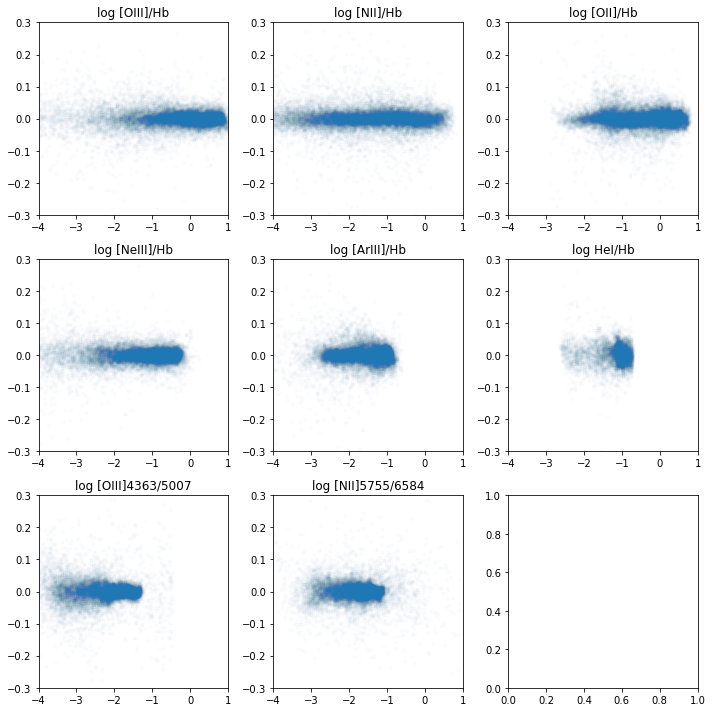

In [10]:
plot1(RM1, figname='SK_ANN_1.png')

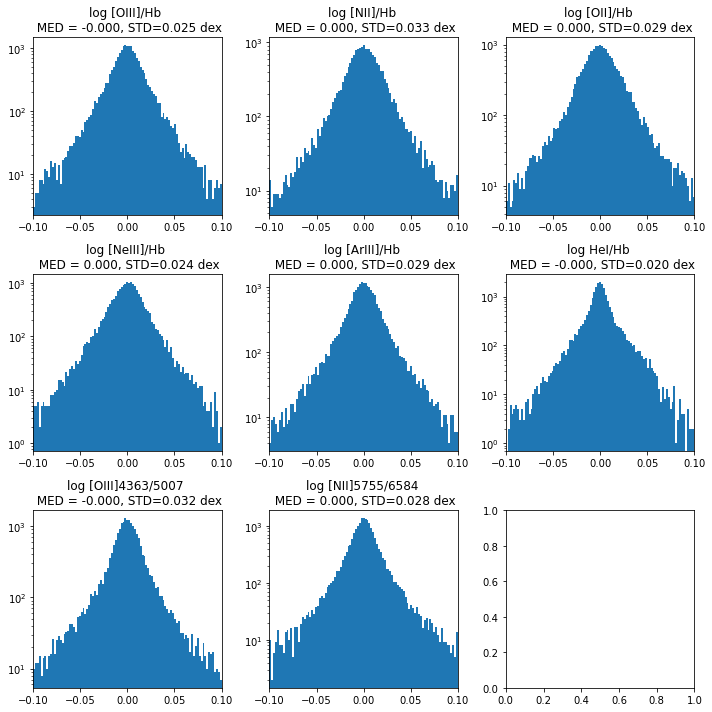

In [50]:
plot2(RM1, figname='SK_ANN_2.png', log=True)

In [12]:
filename = 'Forward10_2'
RM2 = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
if RM2.model_read:
    RM2.predict(scoring=True)
else:
    solver = 'adam' 
    activation = 'tanh'
    RM2 = manage_RM(RM_type='K_ANN', X_train=X_train, y_train=y_train, verbose=True, scaling=True, split_ratio=0.1, random_seed=random_seed)
    RM2.init_RM(solver=solver, activation=activation, 
                hidden_layer_sizes=(50, 50, 50), epochs = 500)
    RM2.train_RM()
    RM2.predict(scoring=True)
    RM2.save_RM(dir_RMs + filename, save_test=True, save_train=True)
RM2.title = 'Keras TensorFlow ANN 500 epochs'
print('Score of training:', RM2.train_score)
print('Score of prediction:', RM2.predic_score)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward10_2.ai4neb_k0


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RM loaded from RMs/Forward10_2.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
Score = 0.999
Predicting from 6 inputs to 8 outputs using 21060 data in 0.43 secs.
Score of training: [0.9988531336879947]
Score of prediction: [0.9988030086230805]


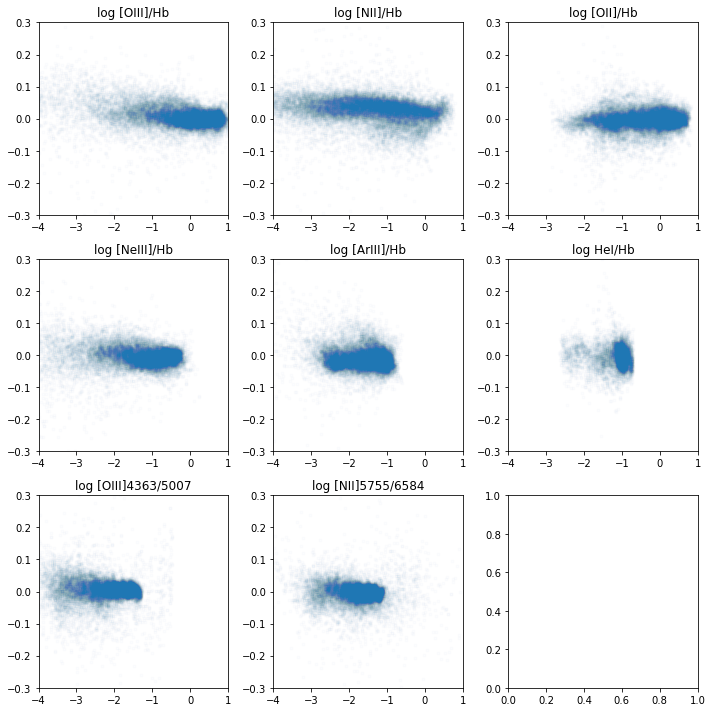

In [13]:
plot1(RM2)

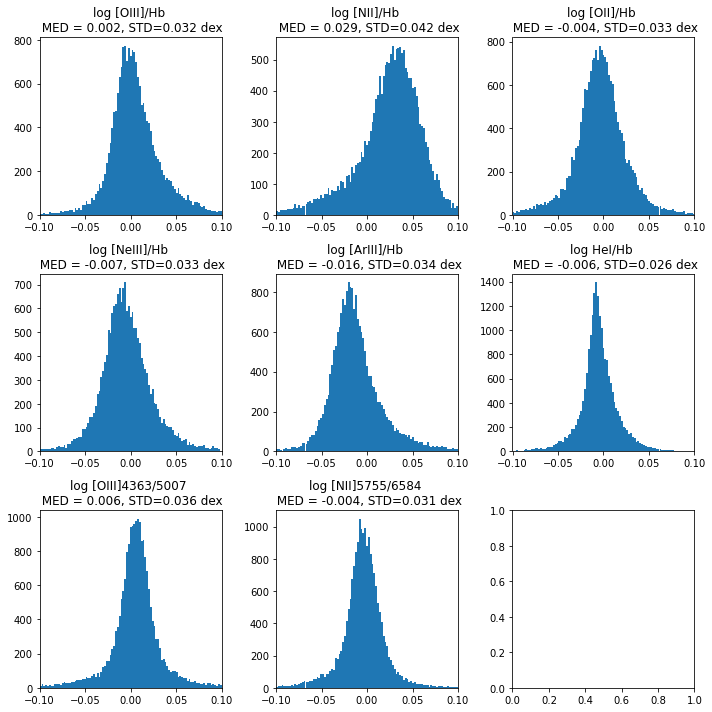

In [14]:
plot2(RM2)

In [15]:
filename = 'Forward10_3'
RM3 = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
if RM3.model_read:
    RM3.predict(scoring=True)
else:
    solver = 'adam' 
    activation = 'tanh'
    RM3 = manage_RM(RM_type='K_ANN', X_train=X_train, y_train=y_train, verbose=True, scaling=True, split_ratio=0.1, random_seed=random_seed)
    RM3.init_RM(solver=solver, activation=activation, 
                hidden_layer_sizes=(50, 50, 50), epochs = 1000)
    RM3.train_RM()
    RM3.predict(scoring=True)
    RM3.save_RM(dir_RMs + 'Forward_3', save_test=True, save_train=True)
RM3.title = 'Keras TensorFlow ANN 1000 epochs'
print('Score of training:', RM3.train_score)
print('Score of prediction:', RM3.predic_score)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward10_3.ai4neb_k0


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RM loaded from RMs/Forward10_3.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
Score = 0.999
Predicting from 6 inputs to 8 outputs using 21060 data in 0.40 secs.
Score of training: [0.9987920623063063]
Score of prediction: [0.9986722354811285]


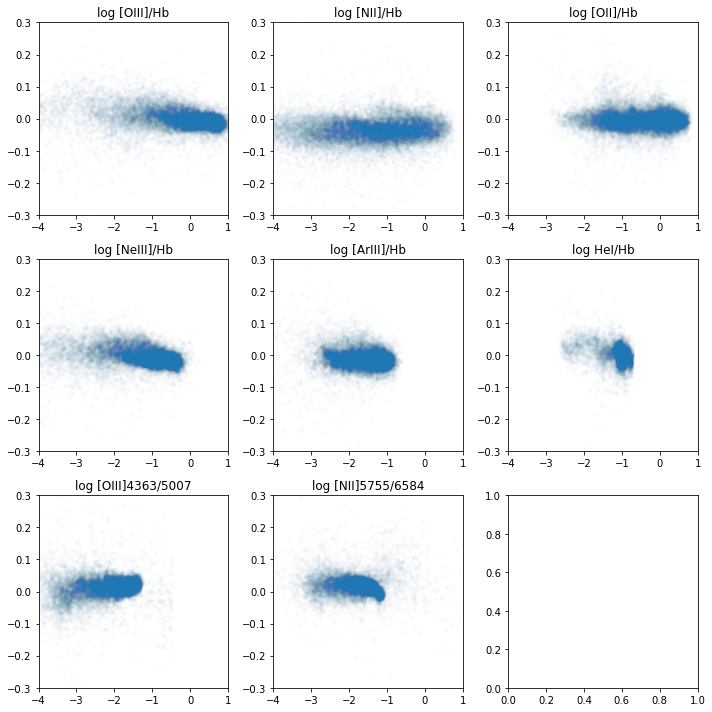

In [16]:
plot1(RM3)

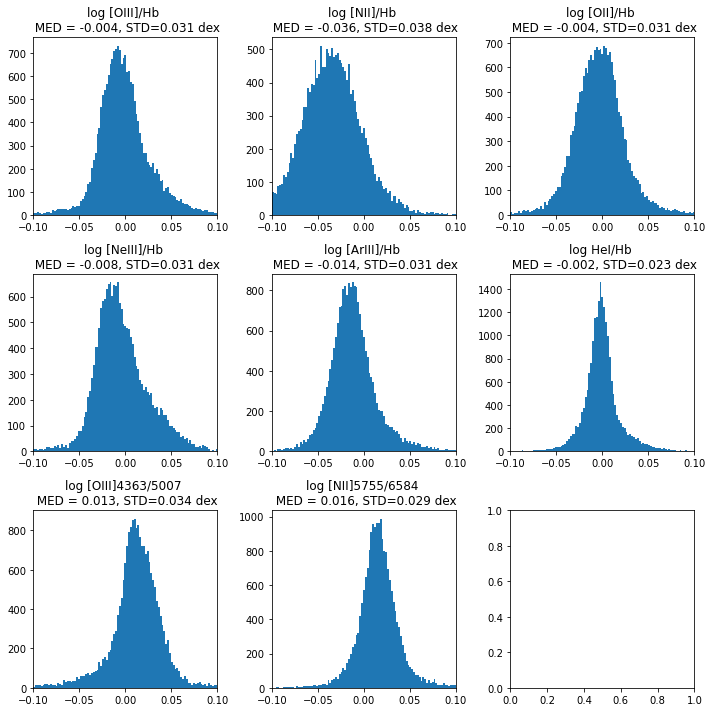

In [17]:
plot2(RM3)

In [18]:
RM4 = manage_RM(RM_type = 'XGB', X_train=X_train, y_train=y_train, scaling=True, split_ratio=0.1, verbose=True, random_seed=random_seed)
print('setup done')
RM4.init_RM(n_estimators=100, max_depth=20, learning_rate=0.08, n_jobs=12)
print('init done')
RM4.train_RM()
print('trained done')
RM4.predict(scoring=True)
print('predict done')
RM4.title = 'XGBoost'
print('Score of training:', RM4.train_score)
print('Score of prediction:', RM4.predic_score)

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 189540, Test set size = 21060
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
setup done
Regression Model XGB
init done
Training 6 inputs for 8 outputs with 189540 data


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', i

In [35]:
RM4 = manage_RM(RM_type = 'XGB', X_train=X_train, y_train=y_train, scaling=True, split_ratio=0.1, verbose=True, random_seed=random_seed)
print('setup done')
RM4.init_RM(n_estimators=500, max_depth=20, learning_rate=0.08, n_jobs=12)
print('init done')
RM4.train_RM()
print('trained done')
RM4.predict(scoring=True)
print('predict done')
RM4.title = 'XGBoost'
print('Score of training:', RM4.train_score)
print('Score of prediction:', RM4.predic_score)

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 189540, Test set size = 21060
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
setup done
Regression Model XGB
init done
Training 6 inputs for 8 outputs with 189540 data


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
RM trained. Score = 1.000
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', i

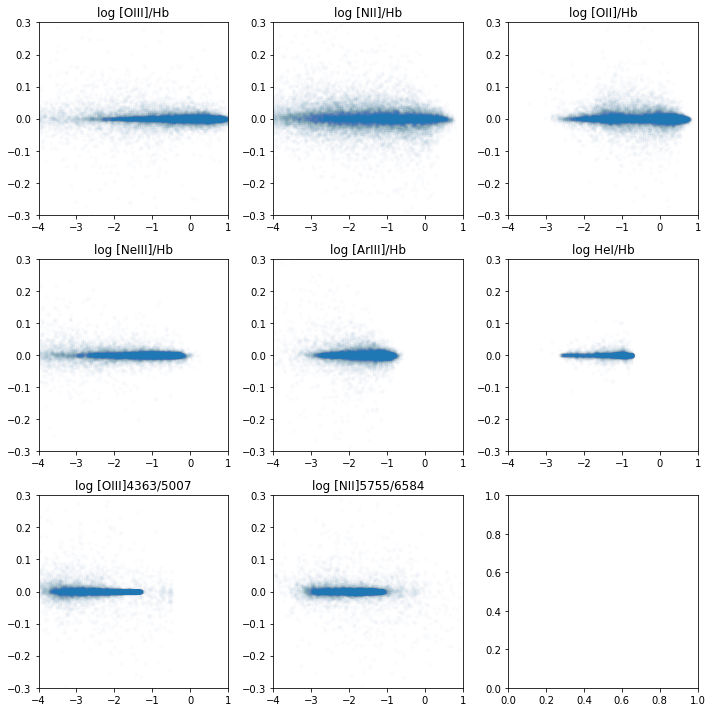

In [36]:
plot1(RM4,figname='XGB_1.png')

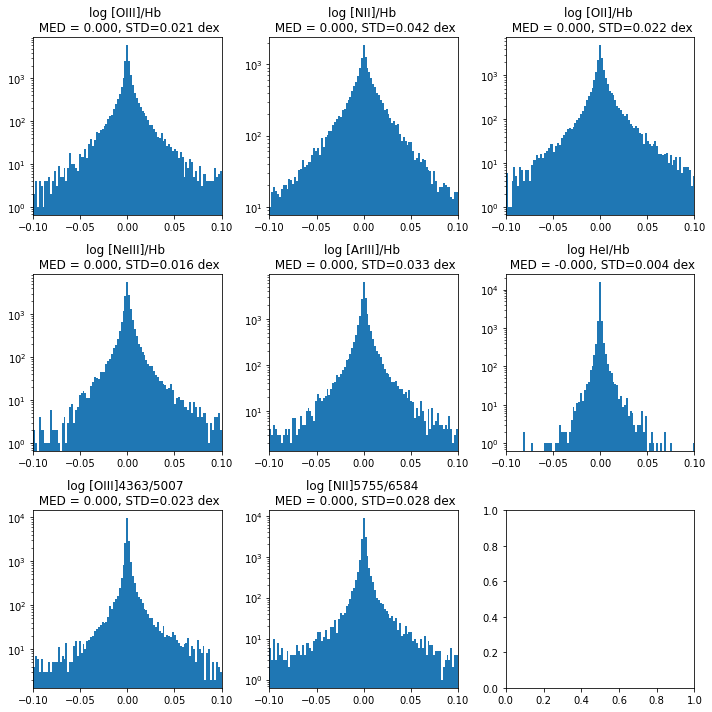

In [44]:
plot2(RM4,figname='XGB_2.png', log=True)

In [28]:
RM6 = manage_RM(RM_type = 'SK_SVM', X_train=X_train, y_train=y_train, scaling=True, split_ratio=0.1, verbose=True, random_seed=random_seed)
print('setup done')
RM6.init_RM()
print('init done')
RM6.train_RM()
print('trained done')
RM6.predict(scoring=True)
print('predict done')
RM6.title = 'SVM'
print('Score of training:', RM6.train_score)
print('Score of prediction:', RM6.predic_score)

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 189540, Test set size = 21060
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
setup done
Regression Model SK_SVM
init done
Training 6 inputs for 8 outputs with 189540 data
RM trained. Score = 0.952
RM trained. Score = 0.969
RM trained. Score = 0.972
RM trained. Score = 0.918
RM trained. Score = 0.887
RM trained. Score = 0.900
RM trained. Score = 0.908
RM trained. Score = 0.878
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf'

In [23]:
filename = 'Forward90_1'
RM1b = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
RM1b.predict(scoring=True)
RM1b.title = 'Forward90_1'
print('Score of training:', RM1b.train_score)
print('Score of prediction:', RM1b.predic_score)

filename = 'Forward90_2'
RM2b = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
RM2b.predict(scoring=True)
RM2b.title = 'Forward90_2'
print('Score of training:', RM2b.train_score)
print('Score of prediction:', RM2b.predic_score)

filename = 'Forward90_3'
RM3b = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
RM3b.predict(scoring=True)
RM3b.title = 'Forward90_3'
print('Score of training:', RM3b.train_score)
print('Score of prediction:', RM3b.predic_score)

filename = 'Forward10_6'
RM6 = manage_RM(RM_filename=dir_RMs + filename, verbose=True)
RM6.predict(scoring=True)
RM6.title = 'Forward90_6 with Dropout'
print('Score of training:', RM6.train_score)
print('Score of prediction:', RM6.predic_score)
print_stats(RM6)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward90_1.ai4neb_sk
Train data scaled. 
Test data scaled. 
Training set size = 21060, Test set size = 189540
Training set size = 21060, Test set size = 189540


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Score = 0.998
Predicting from 6 inputs to 8 outputs using 189540 data in 1.34 secs.
Score of training: [0.999029764852786]
Score of prediction: [0.9982960726717376]
Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward90_2.ai4neb_k0


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RM loaded from RMs/Forward90_2.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 21060, Test set size = 189540
Training set size = 21060, Test set size = 189540
Score = 0.998
Predicting from 6 inputs to 8 outputs using 189540 data in 2.92 secs.
Score of training: [0.9982461586942849]
Score of prediction: [0.9975681162387919]
Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward90_3.ai4neb_k0


/Users/christophemorisset/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RM loaded from RMs/Forward90_3.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 21060, Test set size = 189540
Training set size = 21060, Test set size = 189540
Score = 0.998
Predicting from 6 inputs to 8 outputs using 189540 data in 3.01 secs.
Score of training: [0.9985986270397308]
Score of prediction: [0.9979220894295953]
Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/Forward10_6.ai4neb_k0
RM loaded from RMs/Forward10_6.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 189540, Test set size = 21060
Training set size = 189540, Test set size = 21060
Score = 0.618
Predicting from 6 inputs to 8 outputs using 21060 data in 0.41 secs.
Score of training: [0.620401544206813]
Score of prediction: [0.6184281962529443]
----------Forward90_6 with Dropout----------
Score of training: [0.620401544206813]
Score of prediction: [0.6184281962529443]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb       -9.4e-01 0.38

In [24]:
for rm in (RM1, RM1b, RM2, RM2b,RM3, RM3b):
    print_stats(rm)


----------Scikit ANN----------
Score of training: [0.9993156511788667]
Score of prediction: [0.9992635789561576]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        1.3e-05 0.028 0.040 0.084
log [NII]/Hb         2.6e-04 0.033 0.043 0.094
log [OII]/Hb         5.6e-05 0.029 0.041 0.086
log [NeIII]/Hb       2.2e-04 0.033 0.042 0.093
log [ArIII]/Hb       1.8e-05 0.031 0.038 0.080
log HeI/Hb          -2.1e-04 0.020 0.030 0.057
log [OIII]4363/5007 -1.4e-04 0.032 0.042 0.103
log [NII]5755/6584   1.6e-04 0.029 0.037 0.085
----------Forward90_1----------
Score of training: [0.999029764852786]
Score of prediction: [0.9982960726717376]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb       -2.4e-04 0.041 0.051 0.114
log [NII]/Hb        -9.9e-04 0.044 0.053 0.121
log [OII]/Hb        -8.8e-05 0.040 0.052 0.114
log [NeIII]/Hb       4.1e-04 0.069 0.055 0.136
log [ArIII]/Hb      -2.3e-04 0.045 0.047 0.113
log HeI/Hb          -2.0e-04 0.028 0.038 0.075
log [OIII]4363/5007  1

In [38]:
print_stats(RM4)

----------XGBoost----------
Score of training: [0.9999996519800778, 0.9999991253182238, 0.9999992003954108, 0.999999778183763, 0.999997790167933, 0.9999976250577411, 0.9999985143480907, 0.9999989135209624]
Score of prediction: [0.9994992908245368, 0.9986355246197617, 0.9992147087468155, 0.9998016352313212, 0.9954727727184929, 0.9997367869609708, 0.9987764178139945, 0.9972201846092255]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        9.5e-05 0.027 0.024 0.074
log [NII]/Hb         5.8e-04 0.044 0.054 0.121
log [OII]/Hb         2.2e-04 0.022 0.026 0.069
log [NeIII]/Hb       9.2e-05 0.022 0.022 0.067
log [ArIII]/Hb       6.2e-05 0.039 0.017 0.063
log HeI/Hb          -6.1e-06 0.004 0.003 0.012
log [OIII]4363/5007  6.6e-05 0.023 0.014 0.062
log [NII]5755/6584   7.8e-05 0.028 0.013 0.063


## Combining AI machines

In [82]:
print_stats(RM1, RM2, RM3, RM4)

----------Scikit ANN----------
Score of training: [0.9993156511788667]
Score of prediction: [0.9992635789561576]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        1.5e-04 0.021 0.029 0.058
log [NII]/Hb        -8.5e-04 0.025 0.032 0.068
log [OII]/Hb        -1.6e-03 0.019 0.026 0.055
log [NeIII]/Hb      -2.7e-03 0.026 0.030 0.065
log [ArIII]/Hb      -7.5e-03 0.023 0.025 0.051
log HeI/Hb          -1.9e-03 0.014 0.019 0.036
log [OIII]4363/5007  4.9e-03 0.021 0.026 0.066
log [NII]5755/6584   3.1e-03 0.021 0.022 0.056


In [40]:
print_stats(RM1, RM4)

----------Scikit ANN----------
Score of training: [0.9993156511788667]
Score of prediction: [0.9992635789561576]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        2.5e-04 0.020 0.024 0.058
log [NII]/Hb         6.6e-04 0.030 0.036 0.083
log [OII]/Hb         3.7e-04 0.019 0.026 0.056
log [NeIII]/Hb       3.0e-04 0.021 0.024 0.062
log [ArIII]/Hb       1.4e-04 0.026 0.023 0.055
log HeI/Hb          -9.5e-05 0.011 0.015 0.029
log [OIII]4363/5007  1.9e-05 0.021 0.024 0.067
log [NII]5755/6584   2.2e-04 0.023 0.021 0.057


In [39]:
print_stats(RM1)
print_stats(RM4)
print_stats(RM6)

----------Scikit ANN----------
Score of training: [0.9993156511788667]
Score of prediction: [0.9992635789561576]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        1.3e-05 0.028 0.040 0.084
log [NII]/Hb         2.6e-04 0.033 0.043 0.094
log [OII]/Hb         5.6e-05 0.029 0.041 0.086
log [NeIII]/Hb       2.2e-04 0.033 0.042 0.093
log [ArIII]/Hb       1.8e-05 0.031 0.038 0.080
log HeI/Hb          -2.1e-04 0.020 0.030 0.057
log [OIII]4363/5007 -1.4e-04 0.032 0.042 0.103
log [NII]5755/6584   1.6e-04 0.029 0.037 0.085
----------XGBoost----------
Score of training: [0.9999996519800778, 0.9999991253182238, 0.9999992003954108, 0.999999778183763, 0.999997790167933, 0.9999976250577411, 0.9999985143480907, 0.9999989135209624]
Score of prediction: [0.9994992908245368, 0.9986355246197617, 0.9992147087468155, 0.9998016352313212, 0.9954727727184929, 0.9997367869609708, 0.9987764178139945, 0.9972201846092255]
  y                   Median   STD  Q90%  Q98%
log [OIII]/Hb        9.5e-05 

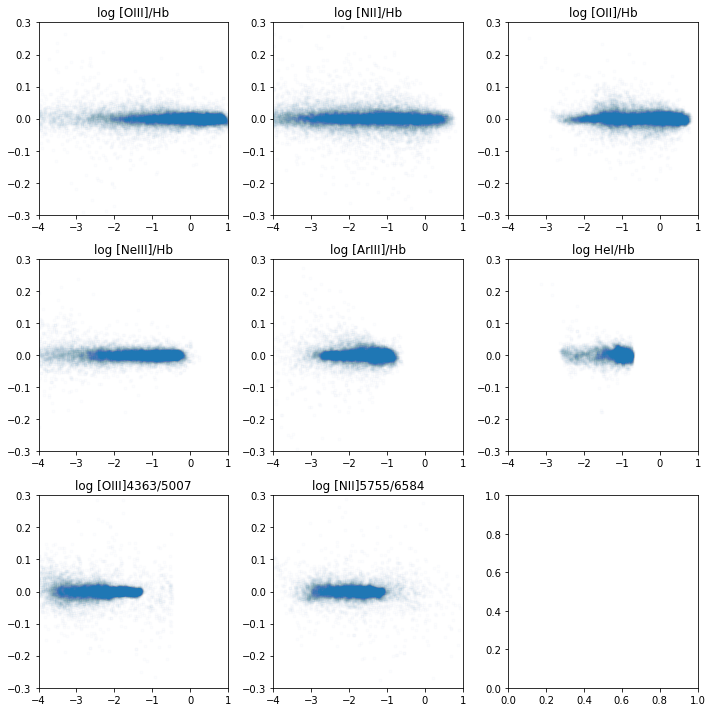

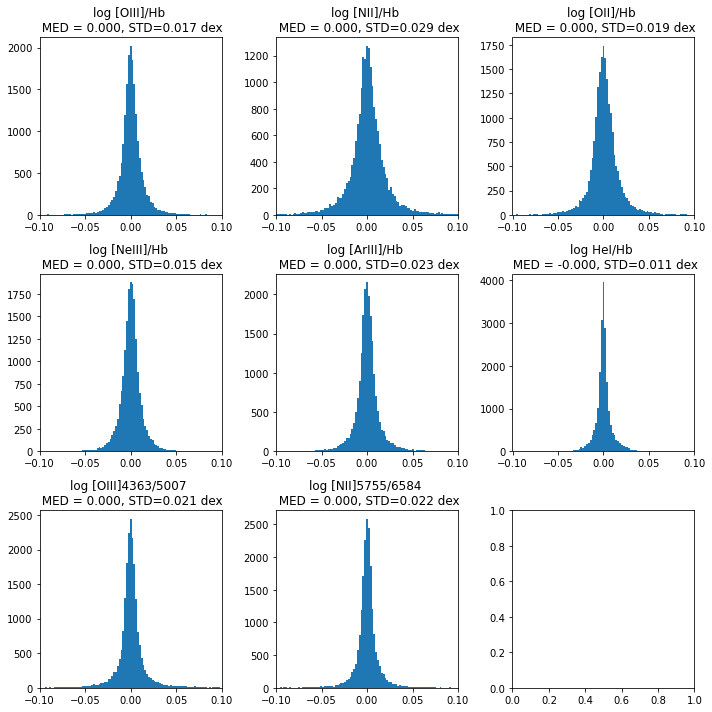

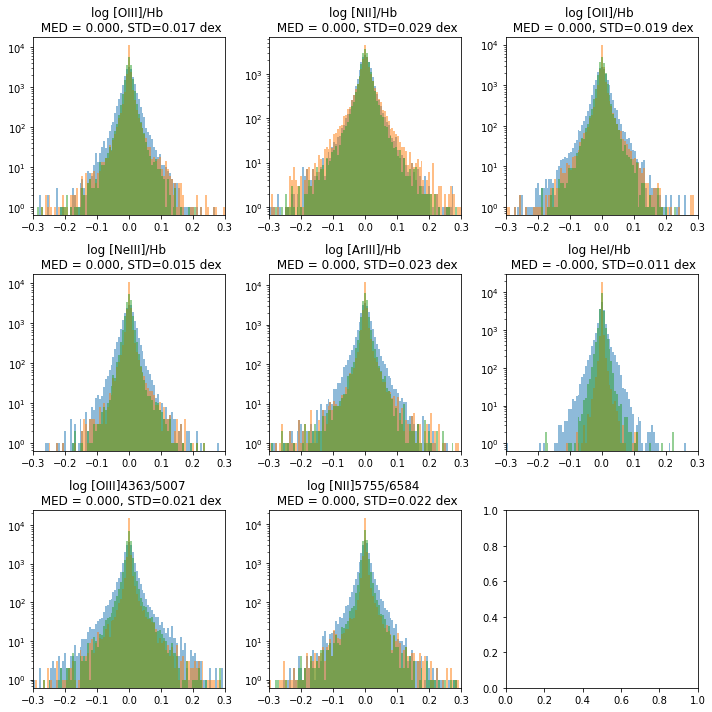

In [57]:
plot1(RM1, RM4)
plot2(RM1, RM4)
f, axes = plt.subplots(3, 3, figsize=(10,10))
plot2(RM1, axes=axes,alpha=0.5, log=True, lims=0.3)
plot2(RM4, axes=axes,alpha=0.5, log=True, lims=0.3)
plot2(RM1, RM4, axes=axes,alpha=0.5, log=True, lims=0.3)